In [1]:
! which python
# ! pip install matplotlib
# ! pip install --upgrade augmentdata
# ! conda install -y keras
# ! pip install pandas
# ! pip install matplotlib

# ! conda install -y tensorflow
# ! conda install -y keras

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/bin/python


In [2]:
# !pip freeze

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import os



In [4]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
import keras
from keras.layers import Dense

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [5]:
from augmentdata import data_augment

In [6]:
def check_cm_others(y_actual,y_predict):
    from sklearn.metrics import confusion_matrix

    cm1 = confusion_matrix(y_actual,y_predict)
    print('Confusion Matrix : \n', cm1)

    total1=sum(sum(cm1))
    #####from confusion matrix calculate accuracy
    accuracy1=(cm1[0,0]+cm1[1,1])/total1
    print ('Accuracy : ', accuracy1)

    tn=cm1[0,0]
    fp=cm1[0,1]
    fn=cm1[1,0]
    tp=cm1[1,1]

    sensitivity1 = tp/(tp+fn)
    print('Sensitivity : ', sensitivity1 )

    specificity1 = tn/(tn+fp)
    print('Specificity : ', specificity1)
    recall=sensitivity1
    precision=tp/(tp+fp)

    print("Precision = ",precision)
    print("Recall = ",recall)

    f1_score=2*(precision*recall)/(precision+recall)

    print("F1 score = ",f1_score)

    return sensitivity1,specificity1,f1_score

In [7]:
def create_model(weight_path,input_dim):
    
    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    model=None
    model = Sequential()
    model.add(Dense(20, input_dim=input_dim, 
                activation='relu')) 

    model.add(Dense(20, 
                activation='relu'))
    model.add(Dense(20, 
                activation='relu'))

    model.add(Dense(20, 
                activation='relu'))

    model.add(Dense(20, 
                activation='relu'))
    model.add(Dense(20, 
                activation='relu'))

    model.add(Dense(2, 
                activation='softmax'))
    opt=keras.optimizers.Adam(lr=.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)



    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model, callbacks_list
    

@relation new-thyroid2

@attribute T3resin integer [65, 144]

@attribute Thyroxin real [0.5, 25.3]

@attribute Triiodothyronine real [0.2, 10.0]

@attribute Thyroidstimulating real [0.1, 56.4]

@attribute TSH_value real [-0.7, 56.3]

@attribute Class {positive, negative}

@inputs T3resin, Thyroxin, Triiodothyronine, Thyroidstimulating, TSH_value

@outputs Class

@data


### Data Pre processing

In [8]:
folder_names=os.listdir("data")
print(folder_names)

['new-thyroid1', 'new-thyroid2']


In [9]:
columns=[
"T3resin", "Thyroxin", "Triiodothyronine", "Thyroidstimulating", "TSH_value","Class"
        ]

In [10]:
df_dict={}
for folder in folder_names:
    print(folder)
    df_dict[folder]={}
    path=os.path.join(os.getcwd(),"data",folder)
    print(path)
    files=os.listdir(path)
    start=0
    train_df=None
    test_df=None
    for file in files:
#         print(file)
        path_to_file=os.path.join(path,file)
        df=pd.read_csv(path_to_file,names=columns, skiprows=12)
        if "tra" in file:
            if train_df is None:
                train_df=df
            else:
                train_df.append(df)
        elif "tst" in file:
            if test_df is None:
                test_df=df
            else:
                test_df.append(df)
    # this part converts class to 0 or 1
    train_df['Class'] = train_df['Class'].astype(str)
    for index,row in train_df.iterrows():
        if row["Class"].strip() == "negative":
            train_df.at[index,'Class'] = 0
        elif row["Class"].strip() == "positive":
            train_df.at[index,'Class'] = 1
        else:
            print("Strange class")
    train_df['Class'] = train_df['Class'].astype(int)    

    test_df['Class'] = test_df['Class'].astype(str)
    for index,row in test_df.iterrows():
        if row["Class"].strip() == "negative":
            test_df.at[index,'Class'] = 0
        elif row["Class"].strip() == "positive":
            test_df.at[index,'Class'] = 1
        else:
            print("Strange class")
    test_df['Class'] = test_df['Class'].astype(int)    
    
    
    
                
    # end of processing all files in the folder
    df_dict[folder]["train"]=train_df
    df_dict[folder]["test"]=test_df

new-thyroid1
/lustre/gfxhome/asislam25/projects/augment/thyroid/data/new-thyroid1
new-thyroid2
/lustre/gfxhome/asislam25/projects/augment/thyroid/data/new-thyroid2


In [11]:
for key,val in df_dict.items():
    print(key) 
    print("Train")
    print(val["train"]["Class"].value_counts())
    
    print("Test")
    print(val["test"]["Class"].value_counts())


new-thyroid1
Train
0    143
1     27
Name: Class, dtype: int64
Test
0    34
1     7
Name: Class, dtype: int64
new-thyroid2
Train
0    142
1     28
Name: Class, dtype: int64
Test
0    34
1     7
Name: Class, dtype: int64


In [12]:
df_dict["new-thyroid1"]["class_index"]=1
df_dict["new-thyroid2"]["class_index"]=1


In [13]:
for key,val in df_dict.items():
    print(key)
    
    print(val["train"]["Class"].value_counts())
    major_count=val["train"]["Class"].value_counts()[0]
    minor_count=val["train"]["Class"].value_counts()[1]
    diff=major_count-minor_count
    df_dict[key]["N"]=diff
    df_dict[key]["Imbalance_Ratio"]=minor_count/major_count
    

new-thyroid1
0    143
1     27
Name: Class, dtype: int64
new-thyroid2
0    142
1     28
Name: Class, dtype: int64


### Running model with no augmentation

In [14]:
# df_dict
results={}
smote_results={}


Going for dataset  new-thyroid1
test shape  (41, 6)
Training model
Time taken to train =  72


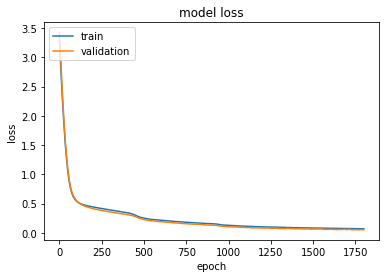

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 605us/step
Accuracy: 95.12
Confusion Matrix : 
 [[33  1]
 [ 1  6]]
Accuracy :  0.9512195121951219
Sensitivity :  0.8571428571428571
Specificity :  0.9705882352941176
Precision =  0.8571428571428571
Recall =  0.8571428571428571
F1 score =  0.8571428571428571
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[34  0]
 [ 5  2]]
Accuracy :  0.8780487804878049
Sensitivity :  0.2857142857142857
Specificity :  1.0
Precision =  1.0
Recall =  0.2857142857142857
F1 score =  0.4444444444444445
Going for dataset  new-thyroid2
test shape  (41, 6)
Training model
Time taken to train =  52


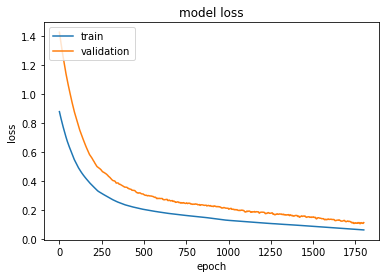

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 600us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6


In [15]:
for key,val in df_dict.items():
    print("Going for dataset ",key)
    results[key]={}
    smote_results[key]={}
    results[key]["0"]={} 
    smote_results[key]["0"]={} 
    train=val["train"]
    test=val["test"]    
    print("test shape ",test.shape)



    source=train[train.columns[:-1]]
    target = list(train["Class"])
    target=pd.get_dummies(target)

    weight_path="weights/"+str(key)+"_wt1.hdf5"    
    model,callbacks_list=create_model(weight_path,source.shape[1])
    start=time.time()
    print("Training model")
    history = model.fit(source.values, target,epochs=1800,validation_split=0.2,callbacks=callbacks_list,verbose=0)
    end=time.time()
    difference = int(end - start)
    print("Time taken to train = ",difference)
    
    

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','validation'], loc='upper left')
    plt.show()    
    
    # load weights
    model.load_weights(weight_path)
    # Compile model (required to make predictions)
    opt=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    print("used model and loaded weights from file")    
    print("Trying MLP")
    y_actual = list(test["Class"])
    y_actual=pd.get_dummies(y_actual)
    test_features_only=test[test.columns[:-1]]
    _, accuracy = model.evaluate(test_features_only.values, y_actual)
    print('Accuracy: %.2f' % (accuracy*100))

    y_actual = test["Class"].astype(int)
    y_actual=np.asarray(y_actual)
    y_predict=model.predict_classes(test_features_only.values)
    sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
    results[key]["0"]["MLP"]=f1_score 
    smote_results[key]["0"]["MLP"]=f1_score     
    
    
    # for other classifiers
    target = list(train["Class"])
    
    # Random forest
    print("RF")
    clf=RandomForestClassifier()
    clf.fit(source.values,target)
    y_predict=clf.predict(test_features_only.values)
    sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
    results[key]["0"]["RF"]=f1_score
    smote_results[key]["0"]["RF"]=f1_score
    
    
#     Gaussian NB
    print("GNB")
    gnb = GaussianNB()
    gnb.fit(source.values,target)
    y_predict = gnb.predict(test_features_only.values)
    sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
    results[key]["0"]["GNB"]=f1_score
    smote_results[key]["0"]["GNB"]=f1_score    
    
#     SVM
    print("SVM")
    clf = svm.SVC()
    clf.fit(source.values,target)
    y_predict=clf.predict(test_features_only.values)
    sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
    results[key]["0"]["SVM"]=f1_score   
    smote_results[key]["0"]["SVM"]=f1_score       



In [16]:
results

{'new-thyroid1': {'0': {'MLP': 0.8571428571428571,
   'RF': 1.0,
   'GNB': 1.0,
   'SVM': 0.4444444444444445}},
 'new-thyroid2': {'0': {'MLP': 1.0,
   'RF': 1.0,
   'GNB': 0.9333333333333333,
   'SVM': 0.6}}}

In [17]:
smote_results

{'new-thyroid1': {'0': {'MLP': 0.8571428571428571,
   'RF': 1.0,
   'GNB': 1.0,
   'SVM': 0.4444444444444445}},
 'new-thyroid2': {'0': {'MLP': 1.0,
   'RF': 1.0,
   'GNB': 0.9333333333333333,
   'SVM': 0.6}}}

### Now augmenting

********* For file  new-thyroid1
(41, 6)
[38, 76, 115]
Time taken to augment =  0
208
After augmentation of  38  items with  1  neighbors
0.0    143
1.0     65
Name: Class, dtype: int64
Training model
Time taken to train =  33


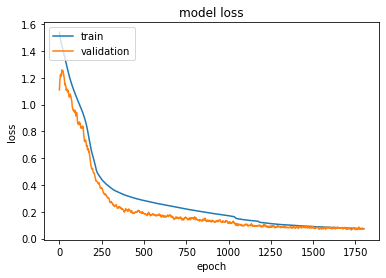

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 602us/step
Accuracy: 97.56
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.45454545454545453
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X:

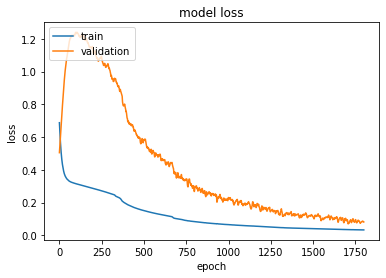

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 641us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
Time taken to augment =  0
208
After augmentation of  38  items with  2  neighbors
0.0    143
1.0     65
Name: Class, dtype: int64
Training model
Time taken to train =  37


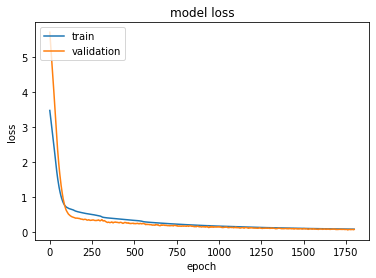

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 672us/step
Accuracy: 97.56
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 5  2]]
Accuracy :  0.8780487804878049
Sensitivity :  0.2857142857142857
Specificity :  1.0
Precision =  1.0
Recall =  0.2857142857142857
F1 score =  0.4444444444444445
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.45454545454545453
Time taken to augment by SMOTE =  0
After OverSampling, the shap

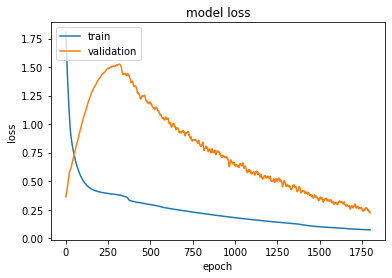

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 678us/step
Accuracy: 97.56
Confusion Matrix : 
 [[34  0]
 [ 1  6]]
Accuracy :  0.975609756097561
Sensitivity :  0.8571428571428571
Specificity :  1.0
Precision =  1.0
Recall =  0.8571428571428571
F1 score =  0.923076923076923
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
Time taken to augment =  0
208
After augmentation of  38  items with  5  neighbors
0.0    143
1.0     65
Name: Class, dtype: int64
Training model
Time taken to train =  16


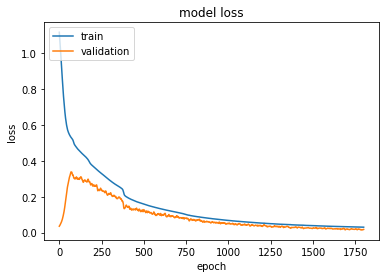

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 670us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.45454545454545453
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (208, 5)
After OverSampling, the shape of train_y: (208,) 

After OverSampling, counts of 

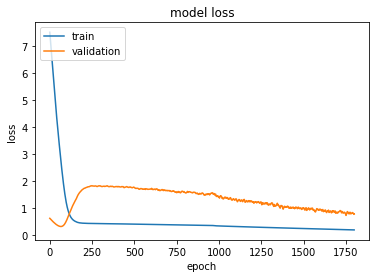

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 682us/step
Accuracy: 17.07
Confusion Matrix : 
 [[ 0 34]
 [ 0  7]]
Accuracy :  0.17073170731707318
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.17073170731707318
Recall =  1.0
F1 score =  0.2916666666666667
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[34  0]
 [ 5  2]]
Accuracy :  0.8780487804878049
Sensitivity :  0.2857142857142857
Specificity :  1.0
Precision =  1.0
Recall =  0.2857142857142857
F1 score =  0.4444444444444445
Time taken to augment =  0
208
After augmentation of  38  items with  10  neighbors
0.0    143
1.0     65
Name: Class, dtype: int64
Training model
Time taken to train =  22


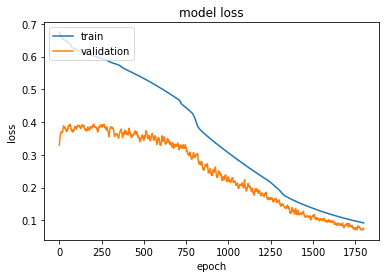

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 660us/step
Accuracy: 97.56
Confusion Matrix : 
 [[34  0]
 [ 1  6]]
Accuracy :  0.975609756097561
Sensitivity :  0.8571428571428571
Specificity :  1.0
Precision =  1.0
Recall =  0.8571428571428571
F1 score =  0.923076923076923
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[34  0]
 [ 2  5]]
Accuracy :  0.9512195121951219
Sensitivity :  0.7142857142857143
Specificity :  1.0
Precision =  1.0
Recall =  0.7142857142857143
F1 score =  0.8333333333333333
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.45454545454545453
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (208, 5)
After OverS

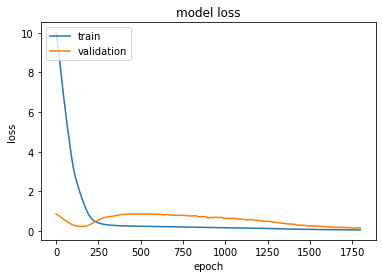

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 701us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
Time taken to augment =  0
246
After augmentation of  76  items with  1  neighbors
0.0    143
1.0    103
Name: Class, dtype: int64
Training model
Time taken to train =  15


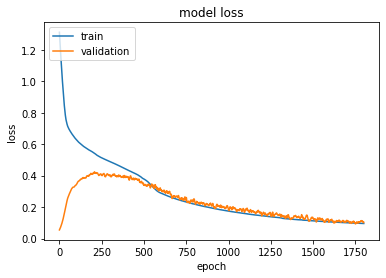

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 657us/step
Accuracy: 82.93
Confusion Matrix : 
 [[34  0]
 [ 7  0]]
Accuracy :  0.8292682926829268
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.7202797202797203
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (246, 5)
After OverSampling, the shape of train_y: (246,) 

After OverSampling, counts of label 1: 103
After OverSampling, counts of other label: 143
Training model
Time taken to train =  15


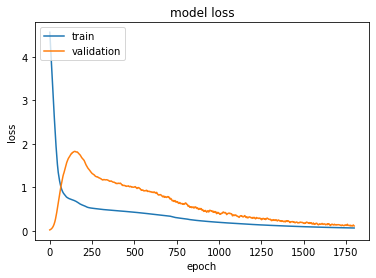

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 676us/step
Accuracy: 17.07
Confusion Matrix : 
 [[ 0 34]
 [ 0  7]]
Accuracy :  0.17073170731707318
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.17073170731707318
Recall =  1.0
F1 score =  0.2916666666666667
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
Time taken to augment =  0
246
After augmentation of  76  items with  2  neighbors
0.0    143
1.0    103
Name: Class, dtype: int64
Training model
Time 

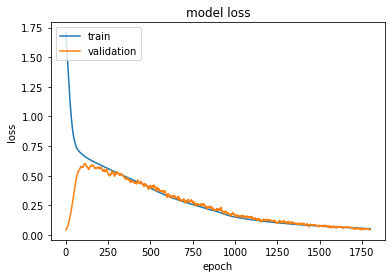

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 668us/step
Accuracy: 82.93
Confusion Matrix : 
 [[34  0]
 [ 7  0]]
Accuracy :  0.8292682926829268
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.7202797202797203
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (246, 5)
After OverSampling, the shape of train_y: (246,) 

After OverSampling, counts of label 1: 103
After OverSampling, counts of other label: 143
Training model
Time taken to train =  48


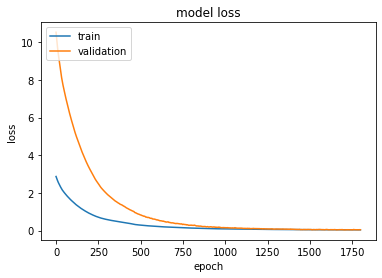

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 736us/step
Accuracy: 97.56
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
Time taken to augment =  0
246
After augmentation of  76  items with  5  neighbors
0.0    143
1.0    103
Name: Class, dtype: int64
Training model
Time t

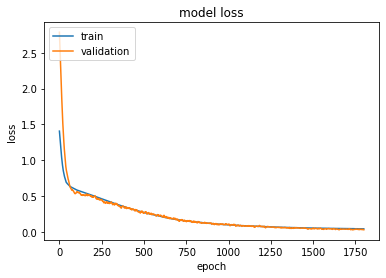

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 672us/step
Accuracy: 97.56
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[34  0]
 [ 2  5]]
Accuracy :  0.9512195121951219
Sensitivity :  0.7142857142857143
Specificity :  1.0
Precision =  1.0
Recall =  0.7142857142857143
F1 score =  0.8333333333333333
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.7202797202797203
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (246, 5)
After OverSampling, the 

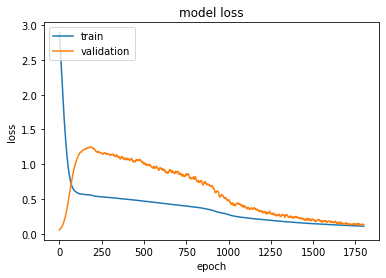

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 663us/step
Accuracy: 17.07
Confusion Matrix : 
 [[ 0 34]
 [ 0  7]]
Accuracy :  0.17073170731707318
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.17073170731707318
Recall =  1.0
F1 score =  0.2916666666666667
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
Time taken to augment =  0
246
After augmentation of  76  items with  10  neighbors
0.0    143
1.0    103
Name: Class, dtype: int64
Training model
Time taken to train =  37


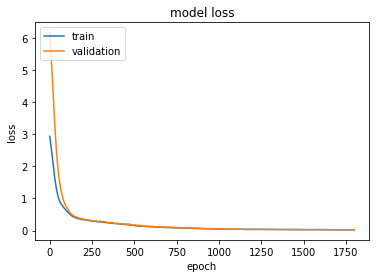

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 676us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[32  2]
 [ 2  5]]
Accuracy :  0.9024390243902439
Sensitivity :  0.7142857142857143
Specificity :  0.9411764705882353
Precision =  0.7142857142857143
Recall =  0.7142857142857143
F1 score =  0.7142857142857143
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.7202797202797203
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (246, 5)
After OverSampling, the shape of train_

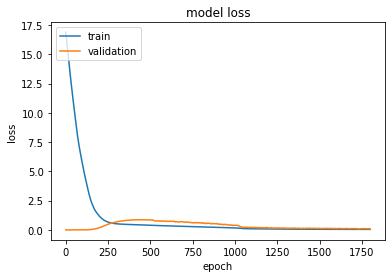

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 681us/step
Accuracy: 17.07
Confusion Matrix : 
 [[ 0 34]
 [ 0  7]]
Accuracy :  0.17073170731707318
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.17073170731707318
Recall =  1.0
F1 score =  0.2916666666666667
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 2  5]]
Accuracy :  0.9512195121951219
Sensitivity :  0.7142857142857143
Specificity :  1.0
Precision =  1.0
Recall =  0.7142857142857143
F1 score =  0.8333333333333333
Time taken to augment =  0
285
After augmentation of  115  items with  1  neighbors
0.0    143
1.0    142
Name: Class, dtype: int64
Training model
Tim

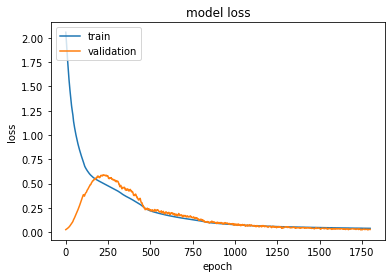

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 640us/step
Accuracy: 97.56
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 1  6]]
Accuracy :  0.975609756097561
Sensitivity :  0.8571428571428571
Specificity :  1.0
Precision =  1.0
Recall =  0.8571428571428571
F1 score =  0.923076923076923
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.993006993006993
Time taken to augment by SMOTE =  0
After OverSampling, the shape of

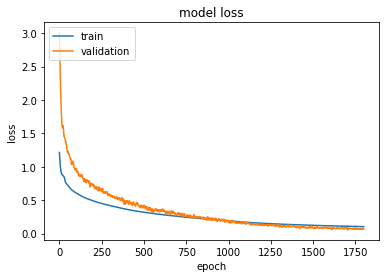

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 663us/step
Accuracy: 97.56
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
Time taken to augment =  0
285
After augmentation of  115  items with  2  neighbors
0.0    143
1.0    142
Name: Class, dtype: int64
Training model
Time taken to train =  17


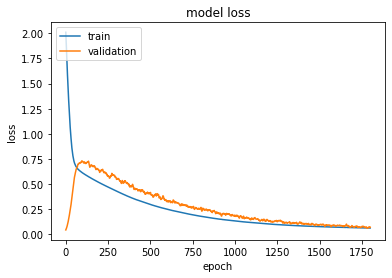

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 669us/step
Accuracy: 82.93
Confusion Matrix : 
 [[34  0]
 [ 7  0]]
Accuracy :  0.8292682926829268
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.993006993006993
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (285, 5)
After OverSampling, the shape of train_y: (285,) 

After OverSampling, counts of label 1: 142
After OverSampling, counts of other label: 143
Training model
Time taken to train =  17


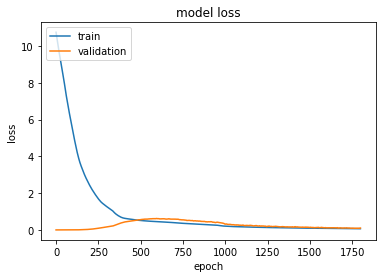

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 667us/step
Accuracy: 17.07
Confusion Matrix : 
 [[ 0 34]
 [ 0  7]]
Accuracy :  0.17073170731707318
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.17073170731707318
Recall =  1.0
F1 score =  0.2916666666666667
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
Time taken to augment =  0
285
After augmentation of  115  items with  5  neighbors
0.0    143
1.0    142
Name: Class, dtype: int64
Training model
Time taken to train =  29


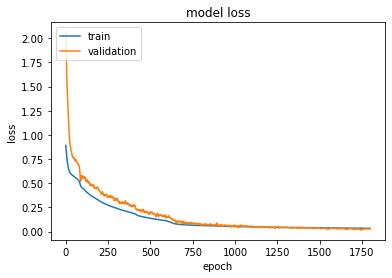

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 657us/step
Accuracy: 97.56
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[33  1]
 [ 2  5]]
Accuracy :  0.926829268292683
Sensitivity :  0.7142857142857143
Specificity :  0.9705882352941176
Precision =  0.8333333333333334
Recall =  0.7142857142857143
F1 score =  0.7692307692307692
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.993006993006993
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (285,

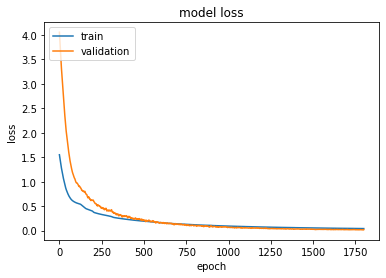

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 726us/step
Accuracy: 97.56
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
Time taken to augment =  0
285
After augmentation of  115  items with  10  neighbors
0.0    143
1.0    142
Name: Class, dtype: int64
Training model
Time taken to train =  18


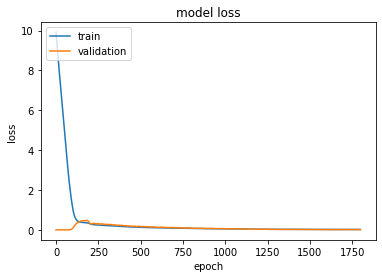

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 680us/step
Accuracy: 82.93
Confusion Matrix : 
 [[34  0]
 [ 7  0]]
Accuracy :  0.8292682926829268
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
SVM
Confusion Matrix : 
 [[31  3]
 [ 2  5]]
Accuracy :  0.8780487804878049
Sensitivity :  0.7142857142857143
Specificity :  0.9117647058823529
Precision =  0.625
Recall =  0.7142857142857143
F1 score =  0.6666666666666666
******Starting SMOTE***********
Shape of training  (170, 5)
143 27
0.993006993006993
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (285, 5)
After OverSampling, the shape of train_y: (285,) 

After OverSampling, counts of label 1: 142
After OverSampling, counts of other label: 143
Training model
Time taken to train =  49


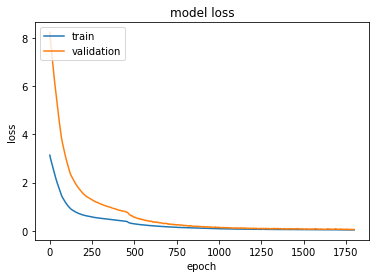

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 736us/step
Accuracy: 97.56
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[32  2]
 [ 2  5]]
Accuracy :  0.9024390243902439
Sensitivity :  0.7142857142857143
Specificity :  0.9411764705882353
Precision =  0.7142857142857143
Recall =  0.7142857142857143
F1 score =  0.7142857142857143
********* For file  new-thyroid2
(41, 6)
[37, 75, 113]
Time taken to augment =  0
207
After augmentation of  37  items wi

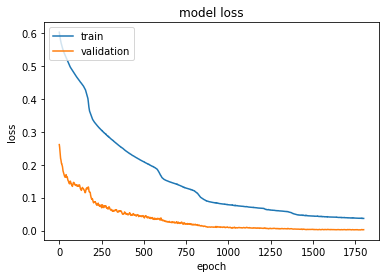

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 666us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.45774647887323944
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (207, 5)
After OverSampling, the shape of tr

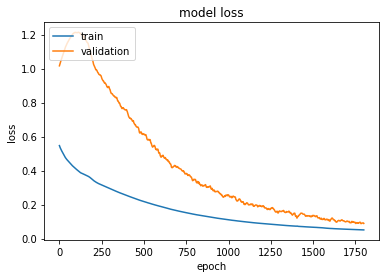

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 682us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
Time taken to augment =  0
207
After augmentation of  37  items with  2  neighbors
0.0    142
1.0     65
Name: Class, dtype: int64
Training model
Time taken to train =  52


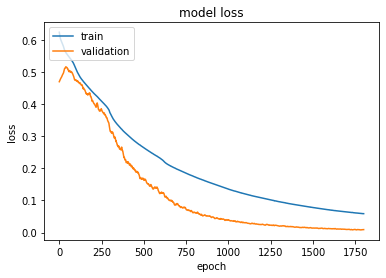

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 686us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.45774647887323944
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (207, 5)
After OverSampling, the shape of tr

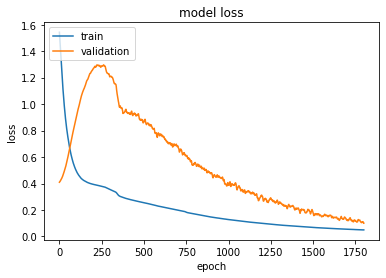

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 622us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
Time taken to augment =  0
207
After augmentation of  37  items with  5  neighbors
0.0    142
1.0     65
Name: Class, dtype: int64
Training model
Time taken to train =  42


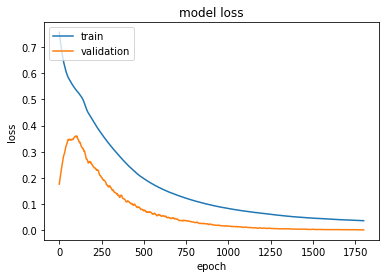

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 589us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.45774647887323944
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (207, 5)
After OverSampling, the

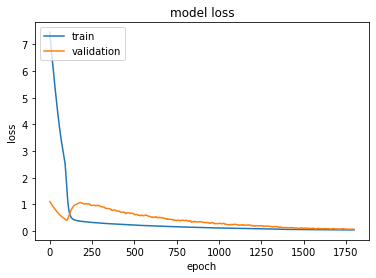

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 601us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
Time taken to augment =  0
207
After augmentation of  37  items with  10  neighbors
0.0    142
1.0     65
Name: Class, dtype: int64
Training model
Time taken to train =  66


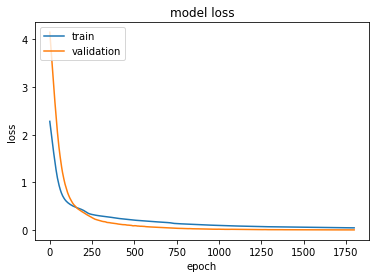

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 663us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.45774647887323944
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (207, 5)
After OverSampling, the shape of tr

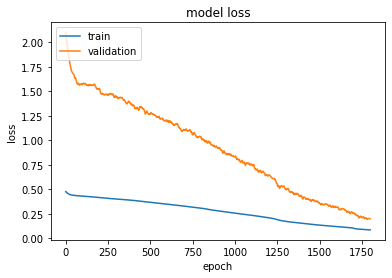

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 623us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 4  3]]
Accuracy :  0.9024390243902439
Sensitivity :  0.42857142857142855
Specificity :  1.0
Precision =  1.0
Recall =  0.42857142857142855
F1 score =  0.6
Time taken to augment =  0
245
After augmentation of  75  items with  1  neighbors
0.0    142
1.0    103
Name: Class, dtype: int64
Training model
Time taken to train =  18


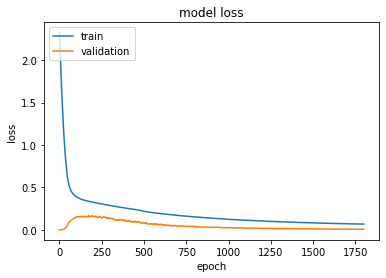

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 635us/step
Accuracy: 82.93
Confusion Matrix : 
 [[34  0]
 [ 7  0]]
Accuracy :  0.8292682926829268
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.7253521126760564
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (245, 5)
After OverSampling, the shape of train_y: (245,) 

After OverSampling, counts of label 1: 103
After OverSampling, counts of other label: 142
Training model
Time taken to train =  23


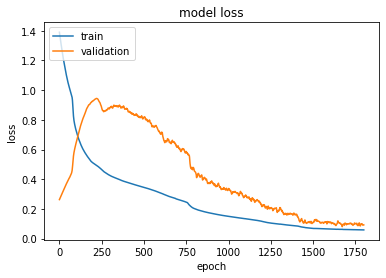

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 603us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
Time taken to augment =  0
245
After augmentation of  75  items with  2  neighbors
0.0    142
1.0    103
Name: Class, dtype: int64
Training model
Time taken to train =  48


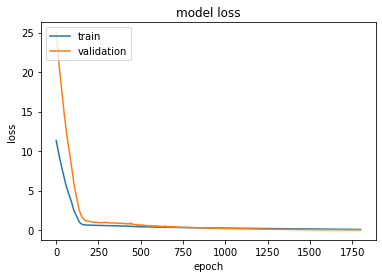

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 670us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 2  5]]
Accuracy :  0.9512195121951219
Sensitivity :  0.7142857142857143
Specificity :  1.0
Precision =  1.0
Recall =  0.7142857142857143
F1 score =  0.8333333333333333
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.7253521126760564
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (245, 5)
After OverSampling, the

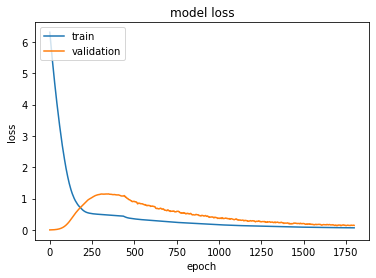

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 608us/step
Accuracy: 17.07
Confusion Matrix : 
 [[ 0 34]
 [ 0  7]]
Accuracy :  0.17073170731707318
Sensitivity :  1.0
Specificity :  0.0
Precision =  0.17073170731707318
Recall =  1.0
F1 score =  0.2916666666666667
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
Time taken to augment =  0
245
After augmentation of  75  items with  5  neighbors
0.0    142
1.0    103
Name: Class, dtype: int64
Training model
Time 

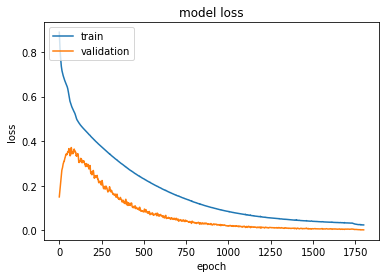

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 648us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 1  6]]
Accuracy :  0.975609756097561
Sensitivity :  0.8571428571428571
Specificity :  1.0
Precision =  1.0
Recall =  0.8571428571428571
F1 score =  0.923076923076923
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.7253521126760564
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (245, 5)
After OverSampling, the s

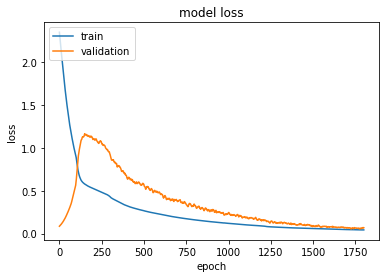

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 722us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
Time taken to augment =  0
245
After augmentation of  75  items with  10  neighbors
0.0    142
1.0    103
Name: Class, dtype: int64
Training model
Time taken to train =  35


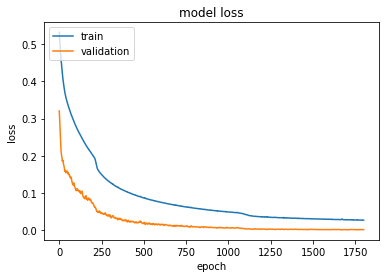

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 680us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 3  4]]
Accuracy :  0.926829268292683
Sensitivity :  0.5714285714285714
Specificity :  1.0
Precision =  1.0
Recall =  0.5714285714285714
F1 score =  0.7272727272727273
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.7253521126760564
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (245, 5)
After OverSampling, the 

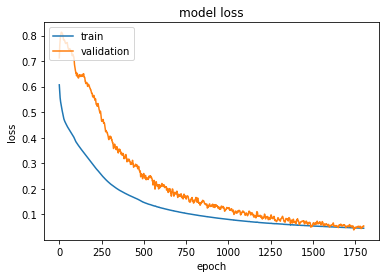

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 685us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 2  5]]
Accuracy :  0.9512195121951219
Sensitivity :  0.7142857142857143
Specificity :  1.0
Precision =  1.0
Recall =  0.7142857142857143
F1 score =  0.8333333333333333
Time taken to augment =  0
283
After augmentation of  113  items with  1  neighbors
0.0    142
1.0    141
Name: Class, dtype: int64
Training model
Time taken to train =  19


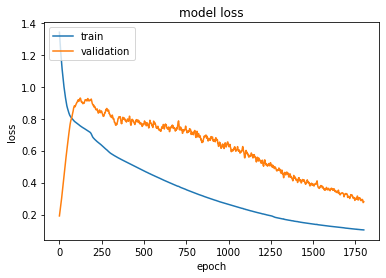

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 596us/step
Accuracy: 82.93
Confusion Matrix : 
 [[34  0]
 [ 7  0]]
Accuracy :  0.8292682926829268
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 1  6]]
Accuracy :  0.975609756097561
Sensitivity :  0.8571428571428571
Specificity :  1.0
Precision =  1.0
Recall =  0.8571428571428571
F1 score =  0.923076923076923
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.9929577464788732
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (283, 5)
After OverS

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Training model
Time taken to train =  34


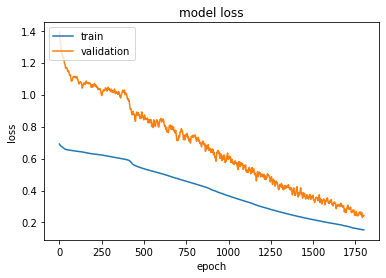

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 673us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 1  6]]
Accuracy :  0.975609756097561
Sensitivity :  0.8571428571428571
Specificity :  1.0
Precision =  1.0
Recall =  0.8571428571428571
F1 score =  0.923076923076923
Time taken to augment =  0
283
After augmentation of  113  items with  2  neighbors
0.0    142
1.0    141
Name: Class, dtype: int64
Training model
Time taken to train =  27


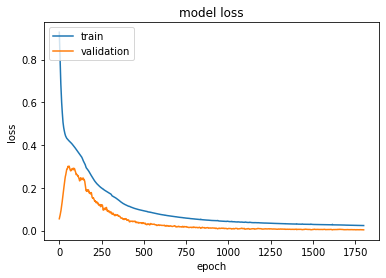

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 630us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 1  6]]
Accuracy :  0.975609756097561
Sensitivity :  0.8571428571428571
Specificity :  1.0
Precision =  1.0
Recall =  0.8571428571428571
F1 score =  0.923076923076923
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.9929577464788732
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (283, 5)
After OverSampling, the s

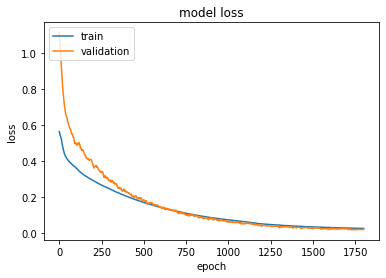

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 621us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 1  6]]
Accuracy :  0.975609756097561
Sensitivity :  0.8571428571428571
Specificity :  1.0
Precision =  1.0
Recall =  0.8571428571428571
F1 score =  0.923076923076923
Time taken to augment =  0
283
After augmentation of  113  items with  5  neighbors
0.0    142
1.0    141
Name: Class, dtype: int64
Training model
Time taken to train =  20


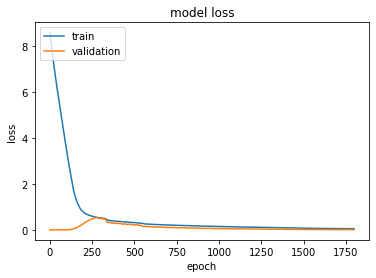

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 642us/step
Accuracy: 82.93
Confusion Matrix : 
 [[34  0]
 [ 7  0]]
Accuracy :  0.8292682926829268
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF


/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[34  0]
 [ 1  6]]
Accuracy :  0.975609756097561
Sensitivity :  0.8571428571428571
Specificity :  1.0
Precision =  1.0
Recall =  0.8571428571428571
F1 score =  0.923076923076923
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.9929577464788732
Time taken to augment by SMOTE =  0
After OverSampling, the shape of train_X: (283, 5)
After OverSampling, the shape of train_y: (283,) 

After OverSampling, counts of label 1: 141
After OverSampling, counts of other label: 142
Training model
Time taken to train =  37


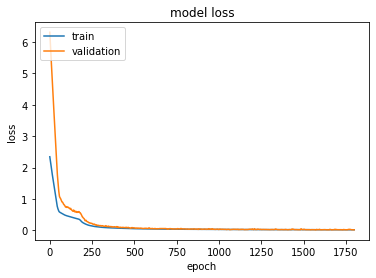

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 598us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[32  2]
 [ 1  6]]
Accuracy :  0.926829268292683
Sensitivity :  0.8571428571428571
Specificity :  0.9411764705882353
Precision =  0.75
Recall =  0.8571428571428571
F1 score =  0.7999999999999999
Time taken to augment =  0
283
After augmentation of  113  items with  10  neighbors
0.0    142
1.0    141
Name: Class, dtype: int64
Training model
Time taken to train =  21


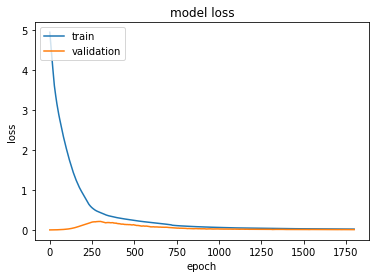

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 605us/step
Accuracy: 82.93
Confusion Matrix : 
 [[34  0]
 [ 7  0]]
Accuracy :  0.8292682926829268
Sensitivity :  0.0
Specificity :  1.0
Precision =  nan
Recall =  0.0
F1 score =  nan
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 1  6]]
Accuracy :  0.9512195121951219
Sensitivity :  0.8571428571428571
Specificity :  0.9705882352941176
Precision =  0.8571428571428571
Recall =  0.8571428571428571
F1 score =  0.8571428571428571
SVM
Confusion Matrix : 
 [[32  2]
 [ 1  6]]
Accuracy :  0.926829268292683
Sensitivity :  0.8571428571428571
Specificity :  0.9411764705882353
Precision =  0.75
Recall =  0.8571428571428571
F1 score =  0.7999999999999999
******Starting SMOTE***********
Shape of training  (170, 5)
142 28
0.9929577464788732
Time taken to augment by SMOTE =  0
A

/lustre/gfxhome/asislam25/.conda/envs/venv_vasic_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


Training model
Time taken to train =  52


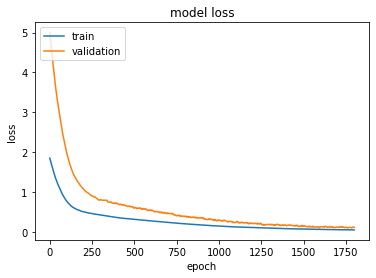

used model and loaded weights from file
Trying MLP
41/41 [==============================] - 0s 628us/step
Accuracy: 100.00
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
RF
Confusion Matrix : 
 [[34  0]
 [ 0  7]]
Accuracy :  1.0
Sensitivity :  1.0
Specificity :  1.0
Precision =  1.0
Recall =  1.0
F1 score =  1.0
GNB
Confusion Matrix : 
 [[33  1]
 [ 0  7]]
Accuracy :  0.975609756097561
Sensitivity :  1.0
Specificity :  0.9705882352941176
Precision =  0.875
Recall =  1.0
F1 score =  0.9333333333333333
SVM
Confusion Matrix : 
 [[32  2]
 [ 1  6]]
Accuracy :  0.926829268292683
Sensitivity :  0.8571428571428571
Specificity :  0.9411764705882353
Precision =  0.75
Recall =  0.8571428571428571
F1 score =  0.7999999999999999


In [18]:
for key,val in df_dict.items():
    print("********* For file ",key)
    train=val["train"]
    test=val["test"]
    print(test.shape)
    deficit=val["N"]
    class_index=val["class_index"]
    N_range=[int(0.33*deficit),int(0.66*deficit),deficit-1]
    print(N_range)
    for N in N_range:
        results[key][N]={}
        smote_results[key][N]={}
        k_range=[1,2,5,10]
        for k in k_range:
            results[key][N][k]={}        
            smote_results[key][N][k]={}                    
            
            daug = data_augment.DataAugment()
            now = time.time()
            randmx=0.5
            [Data_a,Ext_d,Ext_not]=daug.augment(data=train.values,k=k,class_ind=class_index,N=N,randmx=randmx)
            later = time.time()
            difference = int(later - now)
            print("Time taken to augment = ",difference)
            print(len(Data_a))
        
            train_aug=pd.DataFrame(data=Data_a,index=None,    # values                
                    columns=columns)      

            print("After augmentation of ",N," items with ",k," neighbors")
            print(train_aug["Class"].value_counts())
            source=train_aug[train_aug.columns[:-1]]
            target = list(train_aug["Class"])
            target=pd.get_dummies(target)
            
            

            
            weight_path="weights/"+str(key)+"_"+str(N)+"_"+str(k)+"_wt1.hdf5"    
            model,callbacks_list=create_model(weight_path,source.shape[1])
            start=time.time()
            print("Training model")
            history = model.fit(source.values, target,epochs=1800,validation_split=0.2,callbacks=callbacks_list,verbose=0)
            end=time.time()
            difference = int(end - start)
            print("Time taken to train = ",difference)
    
    

            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train','validation'], loc='upper left')
            plt.show()    

            # load weights
            model.load_weights(weight_path)
            # Compile model (required to make predictions)
            opt=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
            model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

            print("used model and loaded weights from file")    
            print("Trying MLP")
            y_actual = list(test["Class"])
            y_actual=pd.get_dummies(y_actual)
            test_features_only=test[test.columns[:-1]]
            _, accuracy = model.evaluate(test_features_only.values, y_actual)
            print('Accuracy: %.2f' % (accuracy*100))            

            
            y_actual = test["Class"].astype(int)
            y_actual=np.asarray(y_actual)
            y_predict=model.predict_classes(test_features_only.values)
            sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
            results[key][N][k]["MLP"]=f1_score 
    
    
            # for other classifiers
            target = list(train_aug["Class"])
            source=train_aug[train_aug.columns[:-1]]
            test_features_only=test[test.columns[:-1]]

            # Random forest
            print("RF")
            clf=RandomForestClassifier()
            clf.fit(source.values,target)
            y_predict=clf.predict(test_features_only.values)
            sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
            results[key][N][k]["RF"]=f1_score 

        #     Gaussian NB
            print("GNB")
            gnb = GaussianNB()
            gnb.fit(source.values,target)
            y_predict = gnb.predict(test_features_only.values)
            sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
            results[key][N][k]["GNB"]=f1_score 

        #     SVM
            print("SVM")
            clf = svm.SVC()
            clf.fit(source.values,target)
            y_predict=clf.predict(test_features_only.values)
            sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
            results[key][N][k]["SVM"]=f1_score 
            
            
            


            # this part for SMOTE
            print("******Starting SMOTE***********")
            source=train[train.columns[:-1]]
            print("Shape of training ",source.shape)

            y_train=train["Class"].values
            num_minority=sum(y_train==class_index)
            num_majority=len(y_train)-num_minority
            print(num_majority,num_minority)

            samp_strategy=(num_minority+N)/num_majority
            print(samp_strategy)
            now = time.time()
            sm = SMOTE(random_state=2,k_neighbors=k,sampling_strategy=samp_strategy)
            X_train_res, y_train_res = sm.fit_sample(source, y_train.ravel())
            source=X_train_res

            later = time.time()
            difference = int(later - now)
            print("Time taken to augment by SMOTE = ",difference)

            print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
            print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

            print("After OverSampling, counts of label {}: {}".format(class_index,sum(y_train_res==1)))
            print("After OverSampling, counts of other label: {}".format(len(y_train_res)-sum(y_train_res==class_index)))  

            weight_path="weights/smote"+"_"+str(key)+"_"+str(N)+"_"+str(k)+"_wt1.hdf5"    
            model,callbacks_list=create_model(weight_path,X_train_res.shape[1])
            start=time.time()
            print("Training model")
            target=pd.get_dummies(y_train_res)
            history = model.fit(X_train_res.values, target,epochs=1800,validation_split=0.2,callbacks=callbacks_list,verbose=0)
            end=time.time()
            difference = int(end - start)
            print("Time taken to train = ",difference) 

            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train','validation'], loc='upper left')
            plt.show()


                    # load weights
            model.load_weights(weight_path)
            # Compile model (required to make predictions)
            opt=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
            model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

            print("used model and loaded weights from file")    
            print("Trying MLP")
            y_actual = list(test["Class"])
            y_actual=pd.get_dummies(y_actual)
            test_features_only=test[test.columns[:-1]]
            _, accuracy = model.evaluate(test_features_only.values, y_actual)
            print('Accuracy: %.2f' % (accuracy*100)) 



            y_actual = test["Class"].astype(int)
            y_actual=np.asarray(y_actual)
            y_predict=model.predict_classes(test_features_only.values)
            sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
            smote_results[key][N][k]["MLP"]=f1_score 

            # for other classifiers
            target = y_train_res
            source=X_train_res
            test_features_only=test[test.columns[:-1]]

            # Random forest
            print("RF")
            clf=RandomForestClassifier()
            clf.fit(source.values,target)
            y_predict=clf.predict(test_features_only.values)
            sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
            smote_results[key][N][k]["RF"]=f1_score 

        #     Gaussian NB
            print("GNB")
            gnb = GaussianNB()
            gnb.fit(source.values,target)
            y_predict = gnb.predict(test_features_only.values)
            sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
            smote_results[key][N][k]["GNB"]=f1_score 

        #     SVM
            print("SVM")
            clf = svm.SVC()
            clf.fit(source.values,target)
            y_predict=clf.predict(test_features_only.values)
            sensitivity,specificity,f1_score=check_cm_others(y_actual,y_predict)
            smote_results[key][N][k]["SVM"]=f1_score
            




In [21]:

results



{'new-thyroid1': {'0': {'MLP': 0.8571428571428571,
   'RF': 1.0,
   'GNB': 1.0,
   'SVM': 0.4444444444444445},
  38: {1: {'MLP': 0.9333333333333333,
    'RF': 1.0,
    'GNB': 0.9333333333333333,
    'SVM': 0.6},
   2: {'MLP': 0.9333333333333333,
    'RF': 1.0,
    'GNB': 0.9333333333333333,
    'SVM': 0.4444444444444445},
   5: {'MLP': 1.0, 'RF': 1.0, 'GNB': 1.0, 'SVM': 0.6},
   10: {'MLP': 0.923076923076923,
    'RF': 1.0,
    'GNB': 1.0,
    'SVM': 0.8333333333333333}},
  76: {1: {'MLP': nan,
    'RF': 1.0,
    'GNB': 0.9333333333333333,
    'SVM': 0.7272727272727273},
   2: {'MLP': nan, 'RF': 1.0, 'GNB': 1.0, 'SVM': 0.7272727272727273},
   5: {'MLP': 0.9333333333333333,
    'RF': 1.0,
    'GNB': 1.0,
    'SVM': 0.8333333333333333},
   10: {'MLP': 1.0, 'RF': 1.0, 'GNB': 1.0, 'SVM': 0.7142857142857143}},
  115: {1: {'MLP': 0.9333333333333333,
    'RF': 1.0,
    'GNB': 0.9333333333333333,
    'SVM': 0.923076923076923},
   2: {'MLP': nan, 'RF': 1.0, 'GNB': 0.9333333333333333, 'SVM': 1.0

In [22]:
smote_results

{'new-thyroid1': {'0': {'MLP': 0.8571428571428571,
   'RF': 1.0,
   'GNB': 1.0,
   'SVM': 0.4444444444444445},
  38: {1: {'MLP': 1.0, 'RF': 1.0, 'GNB': 1.0, 'SVM': 0.6},
   2: {'MLP': 0.923076923076923, 'RF': 1.0, 'GNB': 1.0, 'SVM': 0.6},
   5: {'MLP': 0.2916666666666667,
    'RF': 1.0,
    'GNB': 1.0,
    'SVM': 0.4444444444444445},
   10: {'MLP': 1.0, 'RF': 1.0, 'GNB': 1.0, 'SVM': 0.6}},
  76: {1: {'MLP': 0.2916666666666667,
    'RF': 1.0,
    'GNB': 0.9333333333333333,
    'SVM': 0.7272727272727273},
   2: {'MLP': 0.9333333333333333,
    'RF': 1.0,
    'GNB': 0.9333333333333333,
    'SVM': 0.7272727272727273},
   5: {'MLP': 0.2916666666666667,
    'RF': 1.0,
    'GNB': 1.0,
    'SVM': 0.7272727272727273},
   10: {'MLP': 0.2916666666666667,
    'RF': 1.0,
    'GNB': 0.9333333333333333,
    'SVM': 0.8333333333333333}},
  115: {1: {'MLP': 0.9333333333333333,
    'RF': 1.0,
    'GNB': 0.9333333333333333,
    'SVM': 1.0},
   2: {'MLP': 0.2916666666666667,
    'RF': 1.0,
    'GNB': 0.9333